<h1>Import Library</h1>

In [132]:
import re
import pandas as pd
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

<h1>Baca Data & Hapus Duplikat</h1>

In [133]:
df = pd.read_csv("data_baru_kilang.csv")
df.drop_duplicates(subset=['full_text'], inplace=True)
df.reset_index(drop=True, inplace=True) # Reset index setelah drop
texts = df["full_text"].astype(str)
texts.to_csv("data.csv", index=False)

In [134]:
# Keywords yang menandakan teks relevan dengan topik kilang minyak Pertamina
topic_keywords = [
    "pertamina", "kilang minyak", "refinery", "bbm", "pertalite", "pertamax", 
    "solar", "avtur", "lpg", "spbu", "harga bbm", "subsidi bbm",
    
    # Nama-nama Kilang
    "balongan", "cilacap", "dumai", "plaju", "balikpapan", "kasim", "tuban",
    
    # Event/Isu Terkait
    "kebakaran kilang", "maintenance kilang", "produksi minyak", "impor minyak",
    "pasokan bbm", "mogok kerja", "patra niaga"
]

# Keywords yang menandakan teks tidak relevan atau spam
irrelevant_keywords = [
    # Spam umum
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar",
    
    # Spam spesifik Pertamina (misal: lowongan palsu)
    "lowongan kerja pertamina", "loker pertamina", "rekrutmen pertamina",
    "undian pertamina", "hadiah pertamina", "cek profil saya"
]

# Fungsi Anda sekarang akan bekerja dengan benar untuk topik Anda
def is_relevant(text):
    text_lower = text.lower()
    # Jika ada kata kunci irelevan, langsung buang
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    # Jika tidak ada yang irelevan, cek apakah ada kata kunci topik
    return any(topic in text_lower for topic in topic_keywords)

# Penerapannya tetap sama
mask = df["full_text"].astype(str).apply(is_relevant)
df_filtered = df[mask].reset_index(drop=True)
print(f"Jumlah data setelah pembersihan topik: {len(df_filtered)} baris tersisa.")

Jumlah data setelah pembersihan topik: 1287 baris tersisa.


<h1>PraPemrosesan import Stemmer dari Sastrawi<h1>

In [135]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_nltk = set(stopwords.words('indonesian'))
stop_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stop_words = stop_nltk.union(stop_sastrawi)


tokenizer = RegexpTokenizer(r'\w+')

<h1>Pembersihan data menggunakan case folding</h1>

In [136]:
def case_folding(text):
    text = text.lower()
    return text

In [137]:
singkatan_pertamina_map = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "ngga": "tidak",
    "tdk": "tidak", "tak": "tidak", "ndak": "tidak", "enggak": "tidak",
    "yg": "yang", "dgn": "dengan", "dg": "dengan", "krn": "karena", "karna": "karena",
    "utk": "untuk", "tp": "tapi", "pdhl": "padahal", "sm": "sama", "sma": "sama",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah", "dah": "sudah", "blm": "belum",
    "jd": "jadi", "jg": "juga", "jgn": "jangan", "gmn": "bagaimana", "gimana": "bagaimana",
    "klo": "kalau", "klu": "kalau", "kalo": "kalau", "kl": "kalau",
    "sy": "saya", "gw": "saya", "gue": "saya", "admin": "saya", 
    "bgt": "banget", "skrg": "sekarang", "skr": "sekarang", "td": "tadi", "kmrn": "kemarin",
    "trus": "terus", "trs": "terus", "dr": "dari", "drpd": "daripada",
    "bbrp": "beberapa", "brp": "berapa", "sbg": "sebagai",
    "gpp": "tidak apa apa", "gapapa": "tidak apa apa",
    "thx": "terima kasih", "tq": "terima kasih", "makasih": "terima kasih",
    "ok": "baik", "oke": "baik", "sip": "baik",
    "dll": "", "dst": "", "dsb": "", 
    "wkwk": "", "wkwkwk": "", "haha": "", "hehe": "", "hihi": "",
    "ptm": "pertamina", "ptmn": "pertamina", "pertamini": "pertamina", 
    "bumn": "badan usaha milik negara",
    "esdm": "energi dan sumber daya mineral",
    "bph": "badan pengatur hilir minyak dan gas bumi",
    "skk": "satuan kerja khusus pelaksana kegiatan usaha hulu minyak dan gas bumi",
    "pem": "pemerintah", "pemda": "pemerintah daerah", "pemprov": "pemerintah provinsi", "pemkot": "pemerintah kota",
    "dpr": "dewan perwakilan rakyat",
    "bbm": "bahan bakar minyak",
    "lpg": "elpiji", "elpiji": "elpiji",
    "plt": "pertalite", "prtmx": "pertamax",
    "avtur": "bahan bakar pesawat",
    "spbu": "stasiun pengisian bahan bakar umum",
    "ru": "refinery unit", "refinery unit": "refinery unit",
    "blgn": "balongan", "balongan": "balongan",
    "clcp": "cilacap", "cilacap": "cilacap",
    "bpn": "balikpapan", "balikpapan": "balikpapan",
    "dumai": "dumai",
    "plaju": "plaju",
    "kasim": "kasim",
    "tuban": "tuban",
    "kbkrn": "kebakaran", "kebakaran": "kebakaran",
    "ldkn": "ledakan", "ledakan": "ledakan",
    "bcr": "bocor", "bocoran": "kebocoran",
    "cemar": "pencemaran", "polusi": "polusi",
    "lngk": "langka", "kelangkaan": "kelangkaan",
    "antri": "antrean", "antrian": "antrean",
    "hrg": "harga", "hargo": "harga", 
    "subsidi": "subsidi",
    "nps": "nilai produk samping",
    "tkp": "tempat kejadian perkara",
    "naek": "naik", "turun": "turun", "trun": "turun",
    "aman": "aman", "slmt": "selamat",
    "mhl": "mahal", "murah": "murah",
    "krj": "kerja", "proyek": "proyek",
    "eval": "evaluasi",
    "genjot" : ""
}

# # Define Indonesian stopwords (custom list for simplicity)
# stopwords = set([
#     'genjot'
# ])

<h1>Preprocessing regex, tokenisasi dan pemakaian stemmer</h1>

In [138]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b(pertamina|kilang|minyak|bbm|esdm)\b', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'http\S+|www\S+', ' ', text)     
    text = re.sub(r'@\w+', ' ', text)                
    text = emoji.demojize(text)                      
    text = re.sub(r'\d+', ' ', text)                 
    text = re.sub(r'[^\w\s]', ' ', text)             
    text = re.sub(r'(.)\1{2,}', r'\1', text)         
    text = re.sub(r'\s+', ' ', text).strip()         

    tokens = tokenizer.tokenize(text)

    tokens = [singkatan_pertamina_map.get(w, w) for w in tokens if w not in singkatan_pertamina_map or singkatan_pertamina_map[w] != ""]

    tokens = [w for w in tokens if w not in stop_words]

    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)
# # Function for filtering stopwords
# def filter_tokens(tokens):
#     return [word for word in tokens if word not in stopwords]
    
df["preprocessing"] = texts.apply(clean_text)
# df['tokens_filtered'] = df['preprocessing'].apply(filter_tokens)

In [139]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding": texts.apply(case_folding),
    "preprocessing": df["preprocessing"]
})

df_new.to_csv("data.csv", index=False)

In [140]:
df = pd.read_csv("data.csv")
df.head()

,full_text,case_folding,preprocessing
0,Sejak ada penambahan traffic light laluan perg...,sejak ada penambahan traffic light laluan perg...,tambah traffic light lalu pergi kerja kena ban...
1,355 hari Presiden @prabowo Monitor Yth Bpk Pre...,355 hari presiden @prabowo monitor yth bpk pre...,presiden monitor yth bpk presiden impor singga...
2,@Bambangmulyonoo Malaysia punya kilang dimaksi...,@bambangmulyonoo malaysia punya kilang dimaksi...,malaysia maksimal diindo import negri tetangga...
3,@LahrianSyahilla Pertamina juga memperkuat sek...,@lahriansyahilla pertamina juga memperkuat sek...,kuat sektor hilir tingkat kapasitas efisiensi ...
4,@chunli7 Tak salah beli rumah dan tak salah ta...,@chunli7 tak salah beli rumah dan tak salah ta...,salah beli rumah salah beli rumah salah sorang...


<h1>N-Gram<h1>

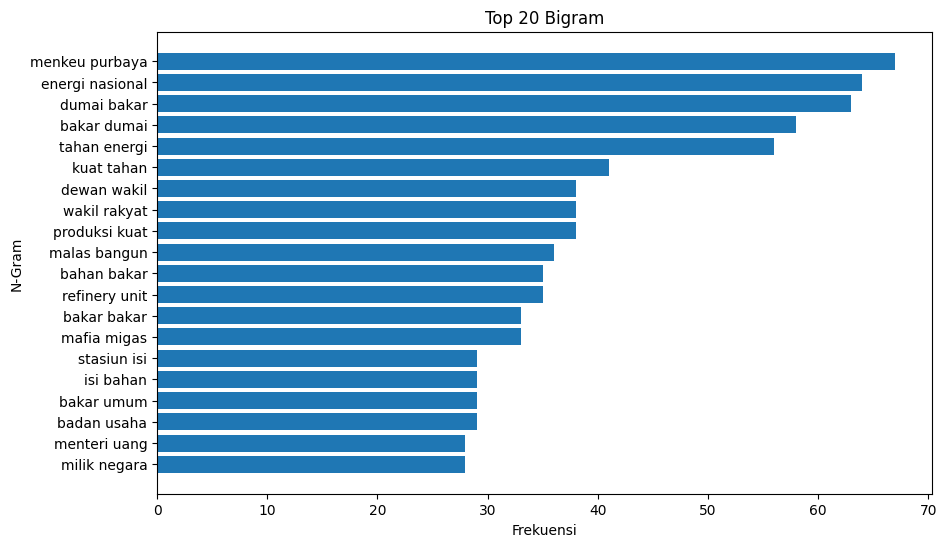

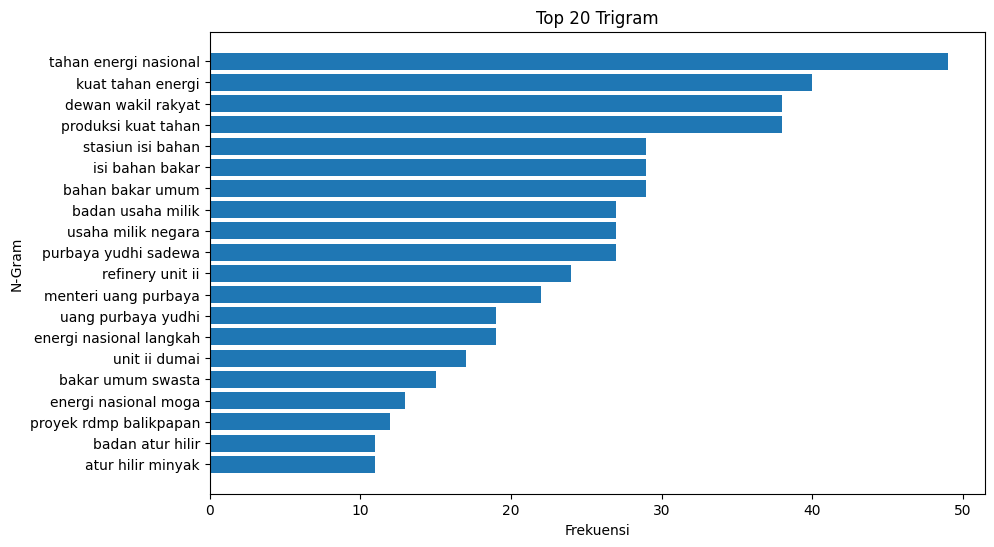

In [141]:
corpus = df_new["preprocessing"].astype(str)

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title="Top N-Grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    ngram_df = pd.DataFrame(words_freq, columns=['NGram', 'Count'])

    plt.figure(figsize=(10,6))
    plt.barh(ngram_df['NGram'][::-1], ngram_df['Count'][::-1])
    plt.title(title)
    plt.xlabel("Frekuensi")
    plt.ylabel("N-Gram")
    plt.show()

# plot_top_ngrams(corpus, ngram_range=(1, 1), title="Top 20 Unigram")
plot_top_ngrams(corpus, ngram_range=(2, 2), title="Top 20 Bigram")
plot_top_ngrams(corpus, ngram_range=(3, 3), title="Top 20 Trigram")

<h1>WordCloud<h1>

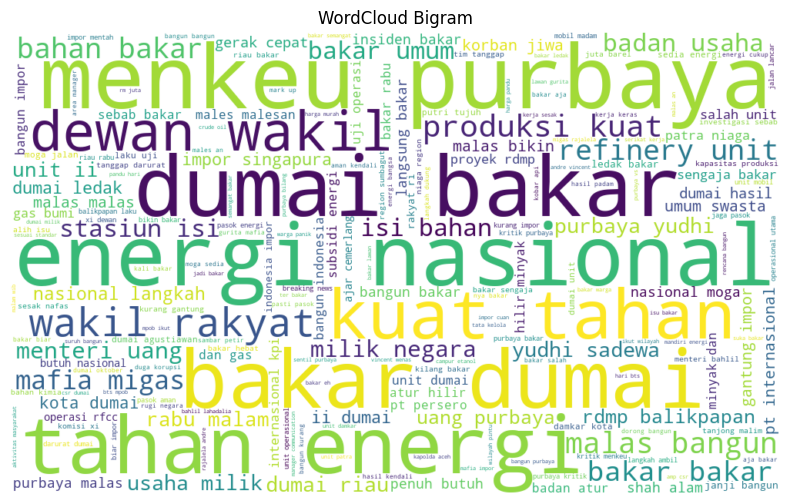

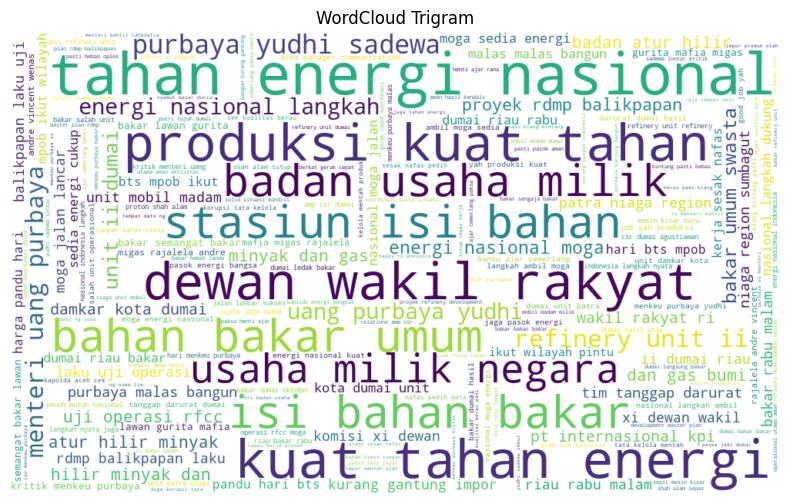

In [143]:
def generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    freq_dict = dict(words_freq)
    
    plt.figure(figsize=(10,6))
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# generate_ngram_wordcloud(corpus, ngram_range=(1,1), title="WordCloud Unigram")
generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram")
generate_ngram_wordcloud(corpus, ngram_range=(3,3), title="WordCloud Trigram")

<h1>Pemanggilan inset_lexicon.json sebagai labeling data (data dilabeling auto)<h1>

In [148]:
with open("inset_lexicon.json", "r", encoding="utf-8") as f:
    inset_lex = json.load(f)

pos_dict = inset_lex.get("positive", {})
neg_dict = inset_lex.get("negative", {})

def label_with_inset(text):
    score = 0.0
    for w in text.split():
        if w in pos_dict:
            score += pos_dict[w]
        elif w in neg_dict:
            score += neg_dict[w]
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"
    
df["preprocessing"] = df["preprocessing"].fillna("")

df["sentiment"] = df["preprocessing"].apply(label_with_inset)
print("Distribusi Sentimen (dengan InSet):\n", df["sentiment"].value_counts())

Distribusi Sentimen (dengan InSet):
 sentiment
positive    975
negative    743
neutral     187
Name: count, dtype: int64


<h1>Pembobotan TF-IDF</h1>

In [149]:
X = df["preprocessing"]
y = df["sentiment"]

vectorizer = TfidfVectorizer(
    max_features=2000,   
    ngram_range=(1,2),   
    sublinear_tf=True,
    min_df=2              
)
X_tfidf = vectorizer.fit_transform(df["preprocessing"])

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

<h1>Modelling dengan tuning GridSearch</h1>

In [150]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto", 0.01, 0.1, 1],
    "degree": [2, 3, 4], 
    "class_weight": [None, "balanced"]
}


grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring="f1_macro",  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (F1-macro):", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Classification Report (Best SVM):\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best Parameters: {'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV Score (F1-macro): 0.6185386085575875
Classification Report (Best SVM):
               precision    recall  f1-score   support

    negative       0.68      0.74      0.71       149
     neutral       0.43      0.27      0.33        37
    positive       0.77      0.77      0.77       195

    accuracy                           0.71       381
   macro avg       0.63      0.59      0.60       381
weighted avg       0.70      0.71      0.70       381



<h1>Evaluasi</h1>

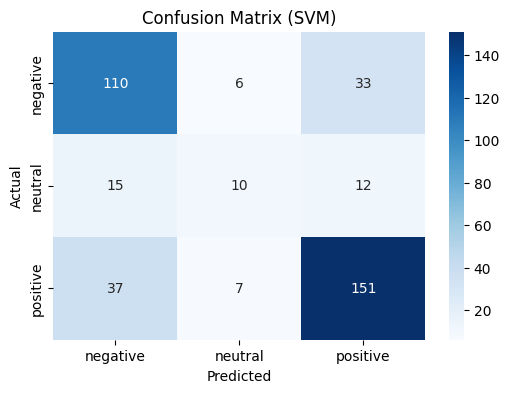

In [151]:
cm = confusion_matrix(y_test, y_pred, labels=best_svm.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.show()


<h1>Visualisasi</h1>

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16428\3271645276.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df,


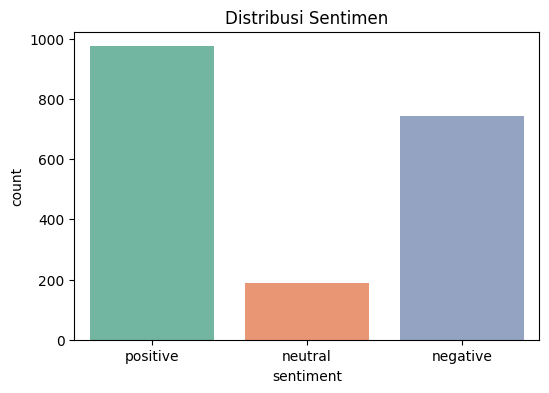

In [152]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df,
              order=["positive","neutral","negative"],
              palette="Set2")
plt.title("Distribusi Sentimen")
plt.show()
